In [9]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from collections import defaultdict
import h5py
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import os
import regex as re
from collections import defaultdict
from scipy.signal import correlate
from scipy.signal import medfilt
import math

In [10]:
def get_Ic_times(t, V, Ic, slope_threshold=-1e2):
    """
    Find times where the slope of voltage vs. time sharply drops,
    indicating critical current transitions.

    Parameters:
    - t: array-like, time values (s)
    - V: array-like, voltage values (mV)
    - slope_threshold: float, negative threshold for sharp slope drop

    Returns:
    - tIc: np.ndarray, times at which critical current transitions occur
    - vIc: np.ndarray, voltages at those times
    """
    time = np.array(t)
    Vsd = np.array(V)
    Isd = np.array(Ic)

    # Median filter to smooth spikes (window size should be odd, adjust as needed)
    Vsd = medfilt(Vsd, kernel_size=11)
    Isd = medfilt(Isd, kernel_size=11)

    from skimage.restoration import denoise_tv_chambolle
    # vsd should be a 1D numpy array
    Vsd = denoise_tv_chambolle(Vsd, weight=0.1)  # Adjust weight as needed
    threshold = 0.03
    
    mask = Vsd < threshold
    crossings = np.diff(mask.astype(int))
    entry_indices = np.where(crossings == 1)[0] + 1    # Downward threshold crossing
    exit_indices  = np.where(crossings == -1)[0] + 1   # Upward threshold crossing

    # # Output
    # print("All Entry Times:", np.array(entry_times))
    # print("Debounced Entry Times:", np.array(exit_times))

    return entry_indices, exit_indices

In [11]:
def calculate_time_delay_and_shift(x, y1, y2):
    """
    Calculate the time delay between two waveforms using FFT-based cross-correlation,
    and return the shifted y2 to align with y1.
    """
    y1 = np.asarray(y1)
    y2 = np.asarray(y2)

    # Normalize
    y1 = (y1 - np.mean(y1)) / np.std(y1)
    y2 = (y2 - np.mean(y2)) / np.std(y2)

    # Use FFT-based correlation for better performance
    correlation = correlate(y1, y2, mode='full', method='fft')

    # Compute lag in number of samples
    lag = np.argmax(correlation) - (len(y2) - 1)

    dt = x[1] - x[0]
    time_delay = lag * dt

    # Pad or crop y2 as needed to align (avoid wrapping with roll)
    if lag > 0:
        # y2 lags behind y1, so shift it forward (prepend zeros)
        y2_shifted = np.pad(y2, (lag, 0), mode='constant')[:len(y2)]
    elif lag < 0:
        # y2 is ahead of y1, shift it backward (cut off front)
        y2_shifted = np.pad(y2, (0, -lag), mode='constant')[-lag:len(y2)-lag]
    else:
        y2_shifted = y2.copy()

    return time_delay, y2_shifted


In [12]:
def plot_trace(file_name, title1, title2):
    data = pd.read_csv(file_name)
    time = data['Time (s)'].values
    Isd = data['Channel 1'].values
    Vsd = data['Channel 3'].values

    plt.figure()
    plt.xlabel('Time (s)')
    plt.ylabel('Isd (µA)')
    plt.title(title1)
    plt.plot(time, Isd, label='Channel 1')

    plt.figure()
    plt.xlabel('Time (s)')
    plt.ylabel('Vsd (V)')
    plt.title(title2)
    plt.plot(time, Vsd, label='Channel 3')

In [13]:
def plot_Ic_distribution(jj_number, frequency):
    Ics_hot = defaultdict(int)
    Ics_cold = defaultdict(int)

    for i in range(1,101):
        data = pd.read_csv(f'JJ{jj_number}_f={frequency}Hz100/JJ{jj_number}_f={frequency}Hz100_trace{i}.csv')
        time = data['Time (s)'].values
        Vsd = data['Channel 3'].values
        Isd = data['Channel 1'].values
        _, Vsd_shifted = calculate_time_delay_and_shift(time, Isd, Vsd)
        entry_indices, exit_indices = get_Ic_times(time, Vsd_shifted, Isd)

        bin_width = 0.01  # Adjust bin width as needed

        def assign_bin(value, bin_width):
            # This will always align bins to multiples of bin_width starting from zero
            bin_start = math.floor(value / bin_width) * bin_width
            bin_end = bin_start + bin_width
            # Use the bin range as the key, or format into string "start-end"
            return f"{bin_start:.3f}-{bin_end:.3f}"


        if len(entry_indices) > 0 and len(exit_indices) > 0:
            for i in range(min(len(entry_indices), len(exit_indices))):
                Ic_hot = Isd[entry_indices[i]]
                Ic_cold = Isd[exit_indices[i]]
                print(Ic_hot, Ic_cold)
                rounded_Ic_hot = round(Ic_hot, 4)
                rounded_Ic_cold = round(Ic_cold, 4)
                print(rounded_Ic_hot, rounded_Ic_cold)
                #bin_label_hot = assign_bin(rounded_Ic_hot, bin_width)
                #bin_label_cold = assign_bin(rounded_Ic_cold, bin_width)
                #Ics_hot[bin_label_hot] += 1
                #Ics_cold[bin_label_cold] += 1
                Ics_hot[rounded_Ic_hot] += 1
                Ics_cold[rounded_Ic_cold] += 1

    plt.figure()
    plt.xlabel('Critical Current (µA)')
    plt.ylabel('Prevalence')
    plt.title(f'Prevalence of Critical Currents: JJ{jj_number} at {frequency}Hz')
    print(list(Ics_hot.values()))
    print(list(Ics_cold.values()))
    plt.scatter(list(Ics_hot.keys()), list(Ics_hot.values()), label='Hot Ic', alpha=0.7)
    plt.scatter(list(Ics_cold.keys()), list(Ics_cold.values()), label='Cold Ic', alpha=0.7)
    plt.legend()
    #plt.scatter(list(Ics.keys()), list(Ics.values()))

In [14]:
def plot_Ic_Voltage_distribution_temperature(jj_number, temperature, file_name):
    Ics = defaultdict(int)

    for i in range(1,11):
        data = pd.read_csv(f'{file_name}_trace{i}.csv')
        time = data['Time (s)'].values
        Vsd = data['Channel 3'].values
        Isd = data['Channel 1'].values
        _, Vsd_shifted = calculate_time_delay_and_shift(time, Isd, Vsd)
        entry_indices, exit_indices = get_Ic_times(time, Vsd_shifted, Isd)

        if len(entry_indices) > 0 and len(exit_indices) > 0:
            for i in range(min(len(entry_indices), len(exit_indices))):
                Ic_hot = Isd[entry_indices[i]]
                Ic_cold = Isd[exit_indices[i]]
                print(Ic_hot, Ic_cold)
                rounded_Ic_hot = round(Ic_hot, 2)
                rounded_Ic_cold = round(Ic_cold, 2)
                print(rounded_Ic_hot, rounded_Ic_cold)
                Ics[rounded_Ic_hot] += 1
                Ics[rounded_Ic_cold] += 1

    plt.figure()
    plt.xlabel('Voltage at Ic time (V)')
    plt.ylabel('Prevalence')
    plt.title(f'Prevalence of Voltages at Critical Current Times: JJ{jj_number} at {temperature}mK')
    print(list(Ics.values()))
    plt.scatter(list(Ics.keys()), list(Ics.values()))

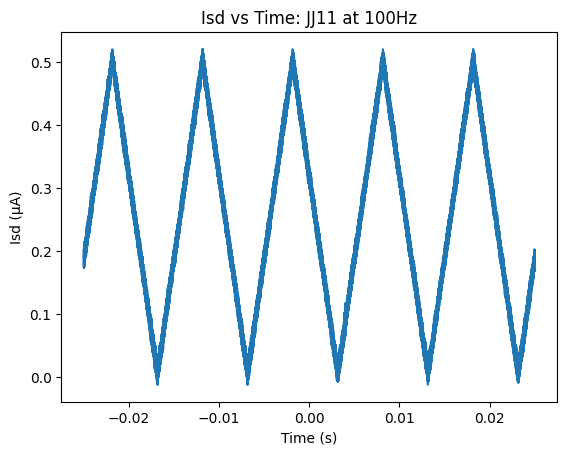

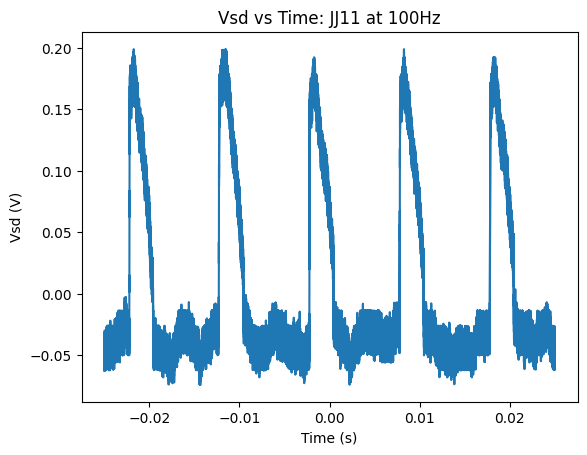

In [20]:
plot_trace('JJ11_f=100Hz_trace1.csv', 'Isd vs Time: JJ11 at 100Hz', 'Vsd vs Time: JJ11 at 100Hz')

Critical current times: [-0.005      -0.00499997 -0.00499996 ...  0.00484737  0.00484738
  0.00484739]
Critical current times: [-0.005      -0.00499999 -0.00499996 ...  0.00485849  0.0048585
  0.00485851]
Critical current times: [-0.005      -0.00499997 -0.00499996 ...  0.00484489  0.00484492
  0.00484493]
Critical current times: [-0.00499999 -0.00499998 -0.00499995 ...  0.00482217  0.00482218
  0.00482221]
Critical current times: [-0.005      -0.00499999 -0.00499998 ...  0.00482531  0.00482534
  0.00482535]
Critical current times: [-0.005      -0.00499999 -0.00499997 ...  0.0048422   0.00484222
  0.00484223]
Critical current times: [-0.005      -0.00499999 -0.00499994 ...  0.00483819  0.00483822
  0.00483823]
Critical current times: [-0.00499999 -0.00499998 -0.00499995 ...  0.00484906  0.00484908
  0.00484909]
Critical current times: [-0.00499998 -0.00499997 -0.00499995 ...  0.0048304   0.00483042
  0.00483045]
Critical current times: [-0.005      -0.00499999 -0.00499997 ...  0.004536

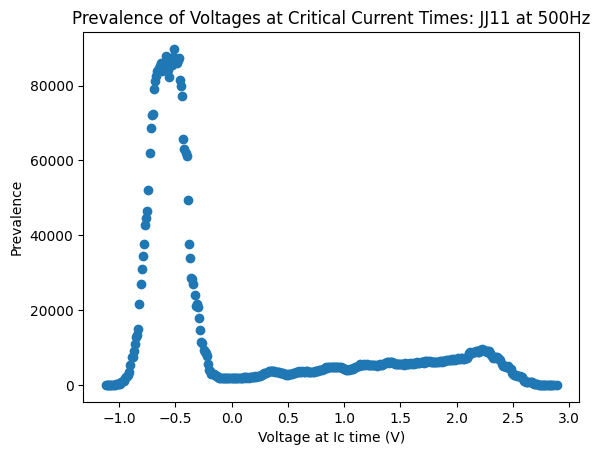

In [27]:
plot_Ic_Voltage_distribution(500)

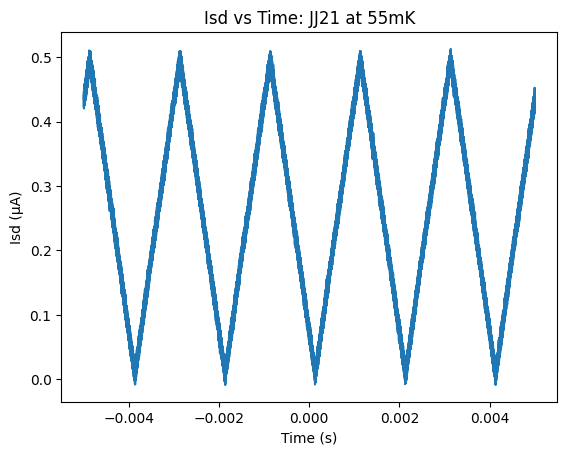

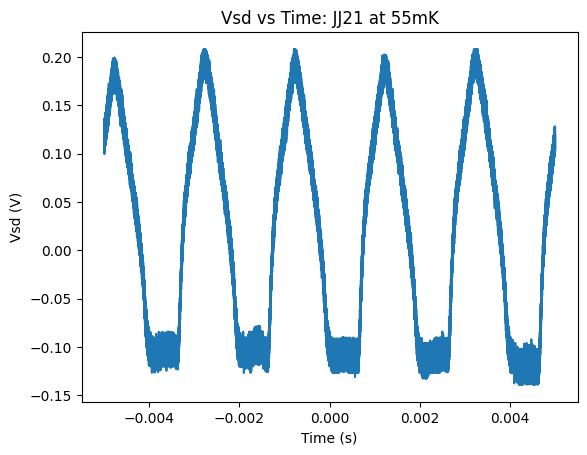

In [28]:
plot_trace('JJ21_Vg=-4.5V_55mK_trace4.csv', 'Isd vs Time: JJ21 at 55mK', 'Vsd vs Time: JJ21 at 55mK')

In [65]:
def plot_trace2(file_name, title1, title2):
    data = pd.read_csv(file_name)
    time = data['Time (s)'].values
    Isd = data['Channel 1'].values
    Vsd = data['Channel 3'].values

    #Correct for offset
    Vsd = Vsd + 0.03

    # Median filter to smooth spikes (window size should be odd, adjust as needed)
    Vsd = medfilt(Vsd, kernel_size=11)
    Isd = medfilt(Isd, kernel_size=11)

    Vsd_shifted = calculate_time_delay_and_shift(time, Isd, Vsd)[1]

    from skimage.restoration import denoise_tv_chambolle
    # vsd should be a 1D numpy array
    Vsd = denoise_tv_chambolle(Vsd, weight=0.1)  # Adjust weight as needed
    threshold = 0.05
    
    mask = Vsd < threshold
    crossings = np.diff(mask.astype(int))
    entry_indices = np.where(crossings == 1)[0] + 1    # Downward threshold crossing
    exit_indices  = np.where(crossings == -1)[0] + 1   # Upward threshold crossing

    entry_times = time[entry_indices]
    exit_times = time[exit_indices]
    
    # # Entry events (left dips)
    # for t in entry_times:
    #     plt.axvline(t, color='green', linestyle='--', label='Entry' if t == entry_times[0] else "")
    # # Exit events (right rises)
    # for t in exit_times:
    #     plt.axvline(t, color='red', linestyle=':', label='Exit' if t == exit_times[0] else "")

    # Output
    print("All Entry Times:", np.array(entry_times))
    print("Debounced Entry Times:", np.array(exit_times))

    #Normalize data
    Vsd_shifted = Vsd_shifted / np.max(np.abs(Vsd_shifted))
    Isd = Isd / np.max(np.abs(Isd))

    plt.figure()
    plt.xlabel('Time (s)')
    plt.ylabel('Isd (µA)')
    plt.title(title1)
    plt.plot(time, Isd, label='Isd - Channel 1')
    plt.plot(time, Vsd_shifted, label='Shifted Vsd', linestyle='--')
    #plt.plot(time, Vsd / np.max(np.abs(Vsd)), label='Unshifted Vsd')

    #plt.xlim(-0.002, 0.002)
    plt.legend()

    plt.figure()
    plt.xlabel('Time (s)')
    plt.ylabel('Vsd (V)')
    #plt.xlim(-0.002, 0.002)
    plt.title(title2)
    plt.plot(time, Vsd, label='Channel 3')

    for t in entry_times:
        plt.axvline(t, color='green', linestyle='--', label='Entry')
    for t in exit_times:
        plt.axvline(t, color='blue', linestyle='--', label='Exit')
    # for t in exit_times:
    #     plt.axvline(t, color='blue', linestyle='--', label='Exit')

All Entry Times: [-0.00424166 -0.00424053 -0.00423948 -0.004237   -0.003251   -0.00325028
 -0.00325026 -0.00223489 -0.00223335 -0.00223246 -0.00223244 -0.00223203
 -0.00223092 -0.00124636 -0.00124448 -0.00124409 -0.00023678 -0.00023546
 -0.00023508 -0.00023506 -0.00023504 -0.00023502 -0.000235   -0.00023498
 -0.00023496 -0.00023438 -0.00023346  0.00075657  0.00075705  0.00075707
  0.00075796  0.00075867  0.00075869  0.00075871  0.00174331  0.00174403
  0.00174497  0.00174499  0.00174543  0.00377163  0.00377276  0.00377433
  0.00377743  0.00476731  0.00476765  0.00476799]
Debounced Entry Times: [-0.00424146 -0.00424021 -0.00423713 -0.00325145 -0.00325071 -0.00325027
 -0.00325013 -0.00223448 -0.00223299 -0.00223245 -0.00223233 -0.00223165
 -0.00124652 -0.00124515 -0.0012443  -0.00124379 -0.00023663 -0.00023509
 -0.00023507 -0.00023505 -0.00023503 -0.00023501 -0.00023499 -0.00023497
 -0.00023464 -0.00023381  0.00075632  0.00075692  0.00075706  0.00075786
  0.00075834  0.00075868  0.000758

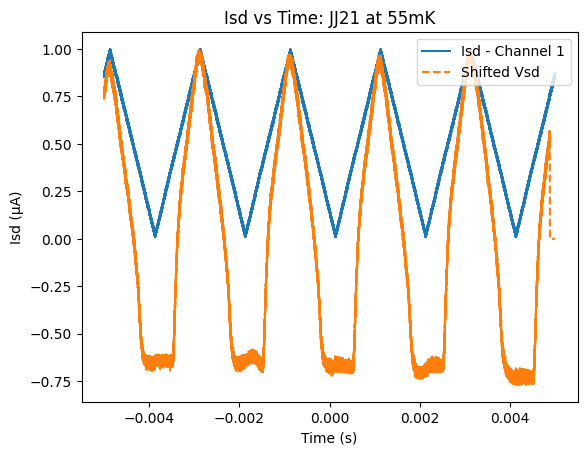

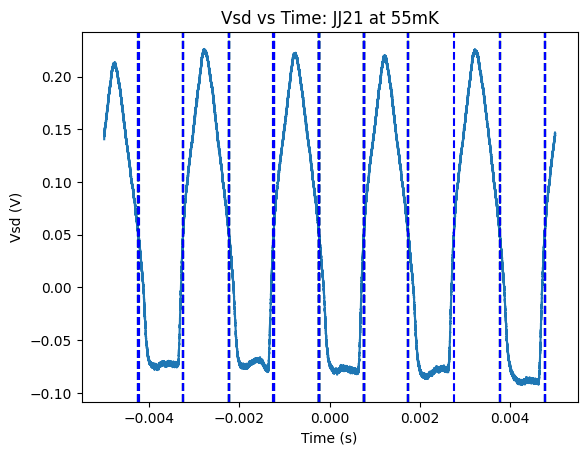

In [66]:
plot_trace2('JJ21_Vg=-4.5V_55mK_trace4.csv', 'Isd vs Time: JJ21 at 55mK', 'Vsd vs Time: JJ21 at 55mK')

[125, 205, 103, 162, 192, 92, 172, 190, 152, 111, 103, 153, 313, 245, 190, 343, 237, 279, 25, 4, 51, 91, 85, 103, 131, 257, 224, 146, 185, 173, 106, 195, 177, 196, 153, 186, 164, 242, 231, 120, 104, 145, 175, 211, 224, 198, 191, 171, 234, 116, 91, 89, 20, 7, 87, 98, 206, 250, 268, 167, 137, 76, 146, 141, 61, 116, 113, 153, 135, 145, 134, 143, 135, 172, 197, 172, 136, 134, 138, 160, 188, 172, 207, 156, 235]


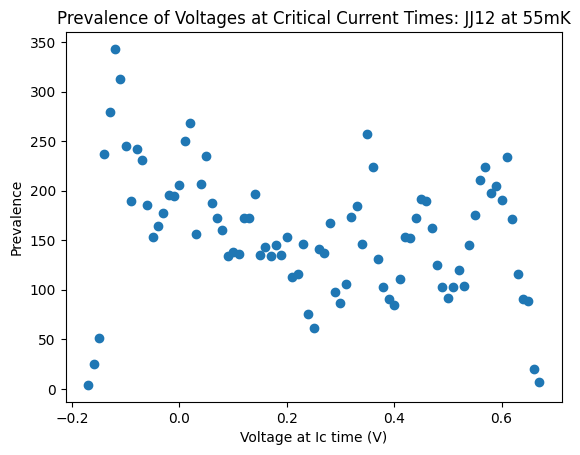

In [35]:
plot_Ic_Voltage_distribution_temperature(12,55,'JJ12_Vg=-4.5V_55mK')

0.3505738129999999 0.385614525
0.3506 0.3856
0.3300894869999999 0.396482415
0.3301 0.3965
0.340463382 0.3507055449999999
0.3405 0.3507
0.3216586389999999 0.3815637659999999
0.3217 0.3816
0.340364583 0.3844289369999999
0.3404 0.3844
0.342373496 0.38907249
0.3424 0.3891
0.340463382 0.3797853839999999
0.3405 0.3798
0.33802634 0.33901433
0.338 0.339
0.3335145189999999 0.3859767879999999
0.3335 0.386
0.328047641 0.3441189449999999
0.328 0.3441
0.350903143 0.3812344359999999
0.3509 0.3812
0.3429992229999999 0.3359844939999999
0.343 0.336
0.3429992229999999 0.4025750199999999
0.343 0.4026
0.338454469 0.378632729
0.3385 0.3786
0.3595974549999999 0.395790822
0.3596 0.3958
0.3507384779999999 0.4025750199999999
0.3507 0.4026
0.3444153419999999 0.376459151
0.3444 0.3765
0.336906618 0.38577919
0.3369 0.3858
0.348927163 0.3778094039999999
0.3489 0.3778
0.3505738129999999 0.341484305
0.3506 0.3415
0.346094925 0.4011918339999999
0.3461 0.4012
0.357358011 0.347774508
0.3574 0.3478
0.4053084589999999 0.

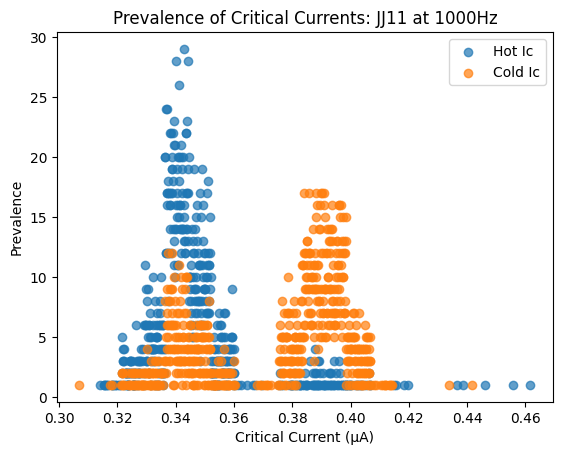

In [ ]:
plot_Ic_distribution(11, 1000)


All Entry Times: [-0.00873444 -0.00672532 -0.00473103 -0.00275779 -0.00073151  0.00126275
  0.00326523  0.00527396  0.0072705   0.00927136]
Debounced Entry Times: [-0.0092653  -0.00728158 -0.00528058 -0.00325871 -0.00124923  0.00074243
  0.00273127  0.00472899  0.00672904  0.0087506 ]


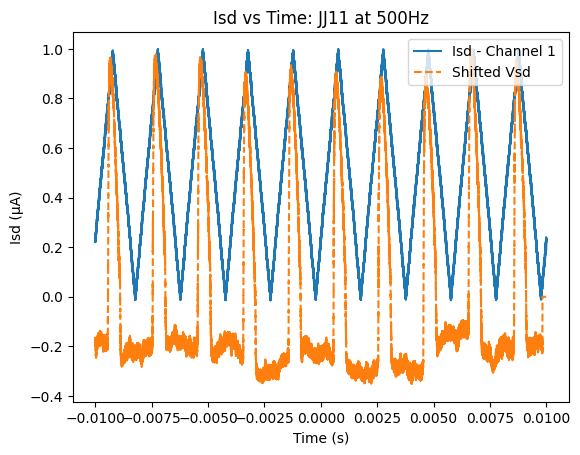

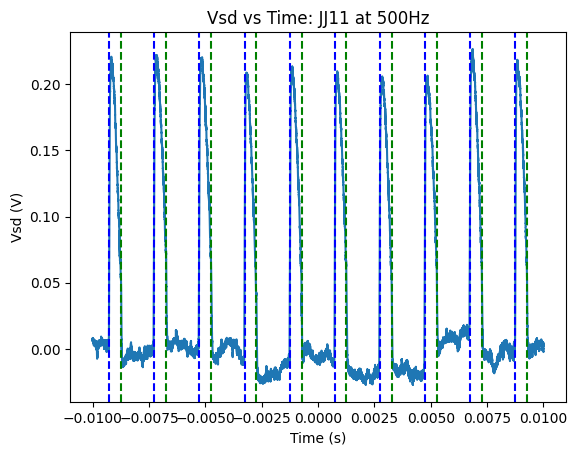

In [51]:
plot_trace2('JJ11_f=500Hz2_trace5.csv', 'Isd vs Time: JJ11 at 500Hz', 'Vsd vs Time: JJ11 at 500Hz')